In [1]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
from data_generation import *
from data_augmentation import perform_augmentation
from utils import mean_iou
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
IMAGE_SIZE = 128
BATCH_SIZE = 8
IMG_CHANNELS = 3
EPOCHS = 5
TRAIN_PATH = 'dataset/stage1_train/'
TEST_PATH = 'dataset/stage1_test/'

#Training AND testing Ids
train_ids = next (os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

print(len(train_ids), len(test_ids))

670 65


Firstly, We read the training images and their respective mask using the class DataGen

In [3]:
gen = DataGen(train_ids, "train", TRAIN_PATH, image_size=IMAGE_SIZE)
X_train, Y_train = gen.__getitems__()

Getting and Resizing train images and masks.....


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [00:33<00:00, 19.89it/s]


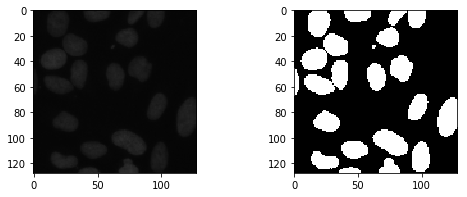

In [6]:
#plotting the corresponding nucleus and its respective mask
index = random.randint(0, len(X_train)-1)

fig, ax = plt.subplots(1, 2, figsize = (8,3))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
ax[0].imshow(X_train[index])
#plt.imshow(np.reshape(y_check[index], (IMAGE_SIZE, IMAGE_SIZE)),cmap='gray')
plt.imshow(np.squeeze(Y_train)[index], cmap='gray')
plt.show()

Performing data augmentation for creating more image samples for training purpose

In [7]:
#data augmentation using predefined class
x, y, x_val, y_val = perform_augmentation(X_train, Y_train, split_size=0.9, BATCH_SIZE=BATCH_SIZE)

In [8]:
#combine generators into one which yields image and masks
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

In [9]:
len(x), len(y), len(x_val), len(y_val)

(76, 76, 9, 9)

In [10]:
from UNet_Model import UNet

In [11]:
getUNet = UNet()

In [13]:
model = getUNet.generate_unet()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128,

In [15]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

earlystopper = EarlyStopping(patience=3, verbose=1)
checkpointer = ModelCheckpoint('dataset/model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=10, steps_per_epoch=250, epochs=3, callbacks=[earlystopper, checkpointer])

Epoch 1/3
250/250 [==============================] - 425s 2s/step - loss: 0.3112 - mean_iou: 0.4601 - val_loss: 0.1010 - val_mean_iou: 0.5554

Epoch 00001: val_loss improved from inf to 0.10100, saving model to dataset/model-dsbowl2018-1.h5
Epoch 2/3
250/250 [==============================] - 420s 2s/step - loss: 0.1092 - mean_iou: 0.6342 - val_loss: 0.0817 - val_mean_iou: 0.6851

Epoch 00002: val_loss improved from 0.10100 to 0.08169, saving model to dataset/model-dsbowl2018-1.h5
Epoch 3/3
250/250 [==============================] - 431s 2s/step - loss: 0.0997 - mean_iou: 0.7110 - val_loss: 0.0855 - val_mean_iou: 0.7314

Epoch 00003: val_loss did not improve from 0.08169


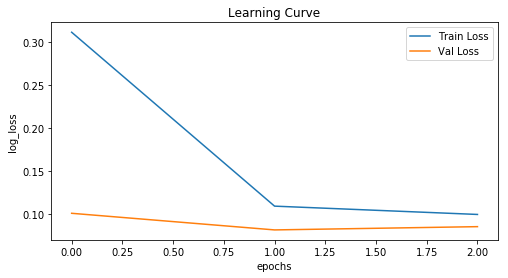

In [16]:
#plotting the learning curve
plt.figure(figsize=(8,4))
plt.plot(results.history['loss'], label='Train Loss')
plt.plot(results.history['val_loss'], label='Val Loss')
#plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.title('Learning Curve')
plt.ylabel('log_loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

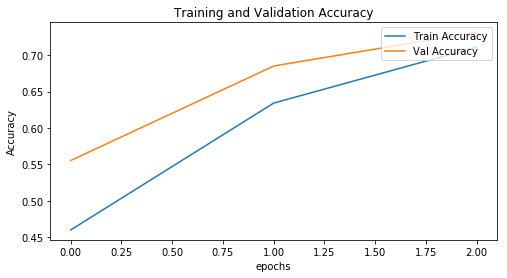

In [34]:
#plotting the learning curve
plt.figure(figsize=(8,4))
plt.plot(results.history['mean_iou'], label='Train Accuracy')
plt.plot(results.history['val_mean_iou'], label='Val Accuracy')
#plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [19]:
from keras.models import load_model
model1 = load_model('dataset/model-dsbowl2018-1.h5', custom_objects={'mean_iou':mean_iou})
preds_train1 = model1.predict(X_train[:int(X_train.shape[0]*0.9)], verbose = 1)
preds_val1 = model1.predict(X_train[int(X_train.shape[0]*0.9):], verbose = 1)

#Threshold predictions
preds_train_thres1 = (preds_train1 > 0.5).astype(np.uint8)
preds_val_thres1 = (preds_val1 > 0.5).astype(np.uint8)

67/67 [==============================] - 3s 51ms/step


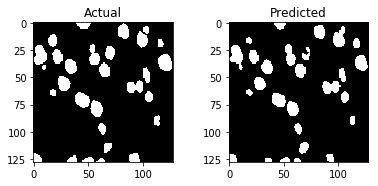

In [23]:
#performing ceck on some random sample
ix = random.randint(0, len(preds_train_thres1))

fig, ax = plt.subplots(1, 2, figsize=(6,4))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
ax[0].imshow(np.squeeze(Y_train[ix]), cmap ='gray')
ax[1].imshow(np.squeeze(preds_train_thres1[ix]), cmap = 'gray')
ax[0].title.set_text('Actual')
ax[1].title.set_text('Predicted')

plt.show()